In [68]:
import cdsapi

import numpy as np

In [69]:
c = cdsapi.Client()

c.retrieve(
    'satellite-soil-moisture',
    {
        'format': 'zip',
        'variable': 'volumetric_surface_soil_moisture',
        'type_of_sensor': 'combined_passive_and_active',
        'time_aggregation': 'day_average',
        'year': '2021',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'type_of_record': 'icdr',
        'version': 'v202012',
    },
    '../data/0_downloads/CDS_soil_moisture.zip')

2023-07-17 17:14:17,417 INFO Welcome to the CDS
2023-07-17 17:14:17,418 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-soil-moisture


2023-07-17 17:14:17,572 INFO Request is completed
2023-07-17 17:14:17,573 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data9/dataset-satellite-soil-moisture-1f0ae505-4bfd-4df6-bdf8-d93483e2d085.zip to ../data/0_downloads/CDS_soil_moisture.zip (700.7M)


KeyboardInterrupt: 

In [ ]:
# extract the zip file
import zipfile
with zipfile.ZipFile('../data/0_downloads/CDS_soil_moisture.zip', 'r') as zip_ref:
    zip_ref.extractall('../data/1_extraction/CDS_soil_moisture')

In [ ]:
# convert each nc file to geotiff
import os
import glob
import subprocess
import rioxarray
import xarray as xr

# create empty dataarray to store values of interest, set "time" as dimension
da = xr.DataArray(
    data=None,
    dims=["time"],
    coords=dict(
        time=[]
    )
)


# get all nc files
nc_files = glob.glob('../data/1_extraction/CDS_soil_moisture/*.nc')

# convert each nc file to geotiff
for nc_file in nc_files:
    # open with rioxarray
    nc = rioxarray.open_rasterio(nc_file)
    # set the CRS
    nc.rio.write_crs("epsg:4326", inplace=True)
    # clip nc for west africa extent
    nc = nc.rio.clip_box(minx=-20, miny=0, maxx=20, maxy=30)

    # append values on a new dataarray
    # values would be xr.where(nc["flag"]==0, nc["sm"], np.nan).plot(vmin=0, vmax=0.6, cmap="YlGnBu")
    # make sure values are float32 and not 'object
    da = xr.concat([da, xr.where(nc["flag"]==0, nc["sm"], np.nan)], dim="time")
    

In [ ]:
# convert all da to float32
da = da.astype('float32')

In [ ]:
for i in range(len(da)):
    da[i,:,:].plot(vmin=0, vmax=0.6, cmap="YlGnBu")
    plt.show()

In [ ]:
# perform gapfilling of the da array along the time dimension using the spline method
da2 = da.interpolate_na(dim="time", method="nearest")

In [ ]:
for i in range(len(da)):
    da2[i,:,:].plot(vmin=0, vmax=0.6, cmap="YlGnBu")
    plt.show()

In [ ]:
# flag the days where values are above 0.09
da3 = xr.where(da2>0.09, 1, 0)

# create da4 that flags where da3 is 1 for at least 20 ** consecutive ** days
da4 = da3.rolling(time=20).sum()

# flag the days where da4 is above 20
da5 = xr.where(da4>=20, 1, 0)

In [ ]:
for i in range(len(da)):
    da5[i,:,:].plot()
    plt.show()

In [ ]:
#flagging values where da5 goes from 1 to 0
da6 = xr.where(da5.diff(dim="time")==-1, 1, 0)

In [ ]:
for i in range(len(da)):
    da6[i,:,:].plot()
    plt.show()

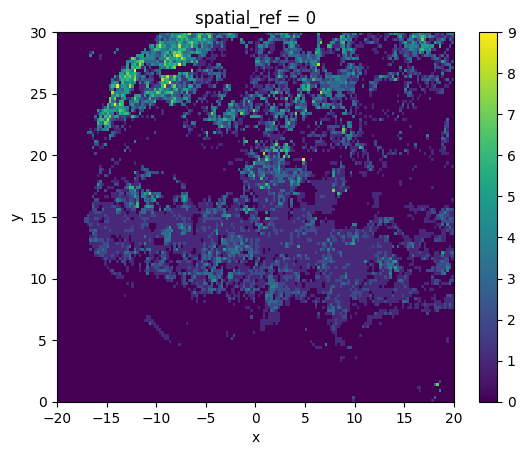

In [ ]:
da6.sum(dim=["time"]).plot()

In [ ]:
# loading dataset
import pandas as pd
locusts = pd.read_csv("./Adults.csv")
locusts["STARTDATE"] = pd.to_datetime(locusts["STARTDATE"])
locusts["STARTDATE"] = locusts["STARTDATE"].apply(lambda x: x.date())
# on retire les lignes dont les coordonnées sont au delà de la zone d'étude, i.e. l'emprise de da6
locusts = locusts[(locusts["Y"]>=0) & (locusts["Y"]<=30) & (locusts["X"]>=-20) & (locusts["X"]<=20)]

In [ ]:
import datetime
locusts = locusts[(locusts["STARTDATE"]>=datetime.date(2021,1,1)) & (locusts["STARTDATE"]<datetime.date(2022,1,1))].reset_index()

In [ ]:
# for each date of the locusts df, make a slice of dataarray that has the same coordinates as da6, on which the pixel undr the coordinates x,y takes 1 as value if LOCPRESENT is 1

# create empty dataarray that has the same shape of da6
da7 = xr.DataArray(
    data=np.nan,
    dims=["time", "y", "x"],
    coords=dict(
        time=da6["time"],
        y=da6["y"],
        x=da6["x"]
    )
)



In [ ]:
from tqdm import tqdm

for i in tqdm(range(len(locusts))):
#i=1
    x = locusts["X"][i]
    y = locusts["Y"][i]
    # get the value of LOCPRESENT
    locpresent = locusts["LOCPRESENT"][i]
    try:
        if locpresent == 1:
            # get the value of the pixel at the coordinates x,y
            da7.loc[da6.sel(x=x, y=y, method="nearest").time.values[i], 
                    da6.sel(x=x, y=y, method="nearest").y.values,
                    da6.sel(x=x, y=y, method="nearest").x.values] = 1

        elif locpresent == 2:
            # get the value of the pixel at the coordinates x,y
            da7.loc[da6.sel(x=x, y=y, method="nearest").time.values[i], 
                    da6.sel(x=x, y=y, method="nearest").y.values,
                    da6.sel(x=x, y=y, method="nearest").x.values] = 0
    except:
        pass


  0%|          | 0/443 [00:00<?, ?it/s]

100%|██████████| 443/443 [00:00<00:00, 454.38it/s]


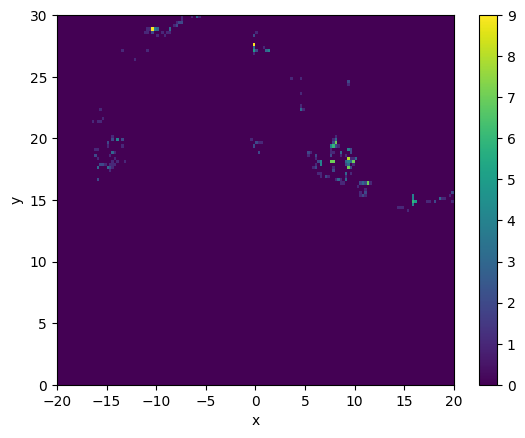

In [ ]:
da7.sum(dim=["time"]).plot()

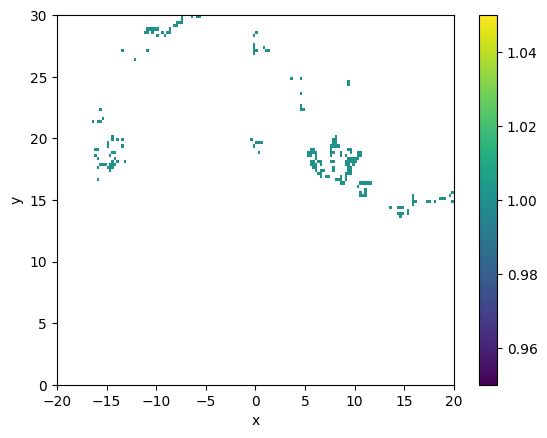

In [181]:
# calculate the mean every 10 days
da7.mean(dim=["time"]).plot()

In [166]:
da7

<xarray.DataArray (time: 364, y: 120, x: 160)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) object 2021-01-02 00:00:00 ... 2021-12-31 00:00:00
  * y        (y) float64 29.88 29.62 29.38 29.12 ... 0.875 0.625 0.375 0.125
  * x        (x) float64 -19.88 -19.62 -19.38 -19.12 ... 19.12 19.38 19.62 19.88

In [ ]:
results = pd.DataFrame({"obs":da7.values.flatten(), "estim":da6.values.flatten()})

In [ ]:
# true positives 
tp = results[(results["obs"]==1) & (results["estim"]==1)].shape[0]
# false positives
fp = results[(results["obs"]==0) & (results["estim"]==1)].shape[0]
# true negatives
tn = results[(results["obs"]==0) & (results["estim"]==0)].shape[0]
# false negatives
fn = results[(results["obs"]==1) & (results["estim"]==0)].shape[0]


In [ ]:
tp, fp, tn, fn

(1, 0, 0, 363)

In [ ]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
precision

1.0

In [ ]:

recall

0.0027472527472527475

In [ ]:
f1 = 2*(precision*recall)/(precision+recall)
f1

0.0054794520547945215

# looping the process

In [162]:
from matplotlib import pyplot as plt

log_score = pd.DataFrame()

for humid_thr in np.arange(0.05, 0.15, 0.01):
    for duration_humid in range(20,21):
        for shift in range(0,1):

            # try:
            #     del da3,da4,da5,da6,da7
            # except:
            #     pass

            # flag the days where values are above 0.09
            da3 = xr.where(da2>humid_thr, 1, 0)
            # da3[10,:,:].plot()
            # plt.show()

            # create da4 that flags where da3 is 1 for at least 20 ** consecutive ** days
            da4 = da3.rolling(time=duration_humid).sum()
            # da4[100,:,:].plot()
            # plt.show()

            # flag the days where da4 is above 20
            da5 = xr.where(da4>=duration_humid, 1, 0)
            # da5[100,:,:].plot()
            # plt.show()

            #flagging values where da5 goes from 1 to 0
            da6 = xr.where(da5.diff(dim="time")==-1, 1, 0)
            # da6[100,:,:].plot()
            # plt.show()

            # loading dataset
            import pandas as pd
            locusts = pd.read_csv("./Adults.csv")
            locusts["STARTDATE"] = pd.to_datetime(locusts["STARTDATE"])
            locusts["STARTDATE"] = locusts["STARTDATE"].apply(lambda x: x.date())
            # on retire les lignes dont les coordonnées sont au delà de la zone d'étude, i.e. l'emprise de da6
            locusts = locusts[(locusts["Y"]>=0) & (locusts["Y"]<=30) & (locusts["X"]>=-20) & (locusts["X"]<=20)]

            locusts = locusts[(locusts["STARTDATE"]>=datetime.date(2021,1,1)) & (locusts["STARTDATE"]<datetime.date(2022,1,1))].reset_index()

            # for each date of the locusts df, make a slice of dataarray that has the same coordinates as da6, on which the pixel undr the coordinates x,y takes 1 as value if LOCPRESENT is 1

            # create empty dataarray that has the same shape of da6
            da7 = xr.DataArray(
                data=np.nan,
                dims=["time", "y", "x"],
                coords=dict(
                    time=da6["time"],
                    y=da6["y"],
                    x=da6["x"]
                )
            )



            from tqdm import tqdm

            for i in tqdm(range(len(locusts))):
            #i=1
                x = locusts["X"][i]
                y = locusts["Y"][i]
                # time is the julian day of the year
                time = locusts["STARTDATE"][i].timetuple().tm_yday
                # get the value of LOCPRESENT
                locpresent = locusts["LOCPRESENT"][i]
                #try:
                if locpresent == 1:
                    # get the value of the pixel at the coordinates x,y
                    da7.loc[da6.sel(x=x, y=y, method="nearest").time[time],
                            da6.sel(x=x, y=y, method="nearest").y.values,
                            da6.sel(x=x, y=y, method="nearest").x.values] = 1

                elif locpresent == 2:
                    # get the value of the pixel at the coordinates x,y
                    da7.loc[da6.sel(x=x, y=y, method="nearest").time[time],
                            da6.sel(x=x, y=y, method="nearest").y.values,
                            da6.sel(x=x, y=y, method="nearest").x.values] = 0
                # except:

                #     pass

            # da7.sum(dim=["time"]).plot()
            # plt.show()

            # results = pd.DataFrame({"obs":da7[shift:,:,:].values.flatten(), "estim":da6[:-shift,:,:].values.flatten()}).dropna()
            results = pd.DataFrame({"obs":da7.values.flatten(), "estim":da6.values.flatten()}).dropna()

            # true positives 
            tp = results[(results["obs"]==1) & (results["estim"]==1)].shape[0]
            # false positives
            fp = results[(results["obs"]==0) & (results["estim"]==1)].shape[0]
            # true negatives
            tn = results[(results["obs"]==0) & (results["estim"]==0)].shape[0]
            # false negatives
            fn = results[(results["obs"]==1) & (results["estim"]==0)].shape[0]

            

            try:
                precision = tp/(tp+fp)
                recall = tp/(tp+fn)
                f1 = 2*(precision*recall)/(precision+recall)
            except:
                precision = np.nan
                recall = np.nan
                f1 = np.nan

            da7_mean = da7.rolling(time=10).mean()[[days for days in range(0,365,10)],:,:].values.flatten()
            da6_mean = da6.rolling(time=10).mean()[[days for days in range(0,365,10)],:,:].values.flatten()

            df_test = pd.DataFrame({"obs":da7_mean, "estim":da6_mean})
            t_test = ttest_ind(df_test["obs"], df_test["estim"])
            
            log_score = log_score.append({"duration_humid":duration_humid, "humid_thr":humid_thr, "shift":shift, 
                                          "tp":tp,
                                           "fp":fp,
                                            "tn":tn,
                                             "fn":fn,
                                              "precision":precision,
                                               "recall":recall,
                                                 "f1":f1,
                                                 "ttest":t_test}, ignore_index=True)



100%|██████████| 443/443 [00:03<00:00, 147.16it/s]


AttributeError: 'DataArrayRolling' object has no attribute 'nanmean'

In [158]:
log_score

,duration_humid,humid_thr,shift,tp,fp,tn,fn,precision,recall,f1,ttest
0,20,0.05,0,0,0,0,309,NaN,NaN,NaN,"(nan, nan)"
1,20,0.06,0,0,0,0,309,NaN,NaN,NaN,"(nan, nan)"
2,20,0.07,0,0,0,0,309,NaN,NaN,NaN,"(nan, nan)"
3,20,0.08,0,0,0,0,309,NaN,NaN,NaN,"(nan, nan)"
4,20,0.09,0,0,0,0,309,NaN,NaN,NaN,"(nan, nan)"
5,20,0.10,0,0,0,0,309,NaN,NaN,NaN,"(nan, nan)"
6,20,0.11,0,1,0,0,308,1.0,0.003236,0.006452,"(nan, nan)"
7,20,0.12,0,1,0,0,308,1.0,0.003236,0.006452,"(nan, nan)"
8,20,0.13,0,0,0,0,309,NaN,NaN,NaN,"(nan, nan)"
9,20,0.14,0,0,0,0,309,NaN,NaN,NaN,"(nan, nan)"


In [125]:
log_score.sort_values(by="f1", ascending=False).head(10)

,duration_humid,humid_thr,shift,tp,fp,tn,fn,precision,recall,f1
8,15.0,0.05,68.0,3.0,0.0,0.0,134.0,1.0,0.021898,0.042857
612,15.0,0.08,72.0,3.0,0.0,0.0,134.0,1.0,0.021898,0.042857
28,16.0,0.05,68.0,3.0,0.0,0.0,134.0,1.0,0.021898,0.042857
441,17.0,0.07,61.0,3.0,0.0,0.0,137.0,1.0,0.021429,0.041958
1042,17.0,0.10,62.0,3.0,0.0,0.0,137.0,1.0,0.021429,0.041958
221,16.0,0.06,61.0,3.0,0.0,0.0,137.0,1.0,0.021429,0.041958
241,17.0,0.06,61.0,3.0,0.0,0.0,137.0,1.0,0.021429,0.041958
401,15.0,0.07,61.0,3.0,0.0,0.0,137.0,1.0,0.021429,0.041958
421,16.0,0.07,61.0,3.0,0.0,0.0,137.0,1.0,0.021429,0.041958
602,15.0,0.08,62.0,3.0,0.0,0.0,137.0,1.0,0.021429,0.041958


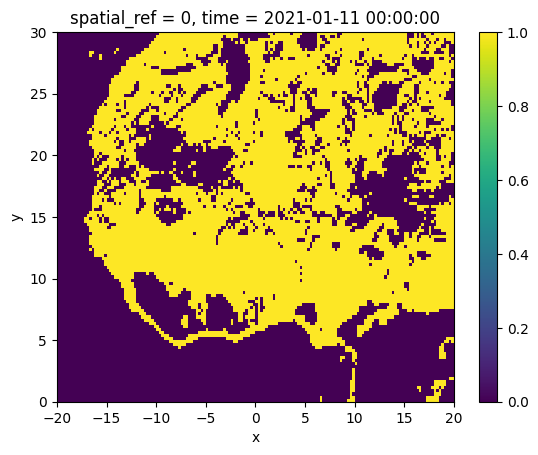

In [163]:
da3[10,:,:].plot()

In [149]:
# calculate da7 mean per period of 10 days

da7_mean = da7.rolling(time=10).mean()[[days for days in range(0,365,10)],:,:].values.flatten()
da6_mean = da6.rolling(time=10).mean()[[days for days in range(0,365,10)],:,:].values.flatten()

df_test = pd.DataFrame({"obs":da7_mean, "estim":da6_mean})

In [147]:
# perform student test on da7_mean and da6_mean

from scipy.stats import ttest_ind

ttest_ind(df_test["obs"], df_test["estim"])

Ttest_indResult(statistic=nan, pvalue=nan)

In [151]:
df_test

,obs,estim
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
710395,NaN,0.0
710396,NaN,0.0
710397,NaN,0.0
710398,NaN,0.0
